In [1]:
import os.path as op
import matplotlib.pyplot as plt
from itertools import compress
import time
import logging
import mne
from mne import events_from_annotations
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from itertools import compress
import mne
import mne_nirs
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from mne_nirs.signal_enhancement import enhance_negative_correlation, short_channel_regression

from mne.preprocessing.nirs import (optical_density,
                                    temporal_derivative_distribution_repair,
                                    scalp_coupling_index)

C:\Users\Admin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [54]:
from collections import OrderedDict


M1_LEFT_ROI_HBO = [
  'S9_D6 hbo',
  'S9_D12 hbo',
  'S9_D13 hbo',
  'S9_D10 hbo',
  'S10_D13 hbo',
  'S6_D13 hbo',
]
M1_LEFT_ROI_HBR = [i.replace('hbo', 'hbr') for i in M1_LEFT_ROI_HBO]
M1_LEFT_ROI = M1_LEFT_ROI_HBO + M1_LEFT_ROI_HBR

S1_LEFT_ROI_HBO = [
  'S15_D18 hbo',
  'S16_D18 hbo',
  'S16_D19 hbo',
  'S16_D23 hbo',
  'S20_D18 hbo',
  'S19_D18 hbo',
  'S23_D18 hbo',
]
S1_LEFT_ROI_HBR = [i.replace('hbo', 'hbr') for i in S1_LEFT_ROI_HBO]
S1_LEFT_ROI = S1_LEFT_ROI_HBO + S1_LEFT_ROI_HBR

REMAINING_LEFT_ROI_HBO = [
  'S13_D12 hbo',
  'S13_D18 hbo',
  'S9_D18 hbo',
  'S16_D16 hbo',
  'S16_D13 hbo',
  'S10_D16 hbo',
]
REMAINING_LEFT_ROI_HBR = [i.replace('hbo', 'hbr') for i in REMAINING_LEFT_ROI_HBO]
REMAINING_LEFT_ROI = REMAINING_LEFT_ROI_HBR + REMAINING_LEFT_ROI_HBO


SMZ_LEFT_ROI_HBO = S1_LEFT_ROI_HBO + M1_LEFT_ROI_HBO + REMAINING_LEFT_ROI_HBO
SMZ_LEFT_ROI_HBR = S1_LEFT_ROI_HBR + M1_LEFT_ROI_HBR + REMAINING_LEFT_ROI_HBR
SMZ_LEFT_ROI = S1_LEFT_ROI + M1_LEFT_ROI + REMAINING_LEFT_ROI

######################

M1_RIGHT_ROI_HBO = [
  'S12_D9 hbo',
  'S12_D15 hbo',
  'S12_D11 hbo',
  'S11_D14 hbo',
  'S12_D14 hbo',
  'S7_D14 hbo',
]
M1_RIGHT_ROI_HBR = [i.replace('hbo', 'hbr') for i in M1_RIGHT_ROI_HBO]
M1_RIGHT_ROI = M1_RIGHT_ROI_HBO + M1_RIGHT_ROI_HBR

S1_RIGHT_ROI_HBO = [
  'S18_D21 hbo',
  'S17_D21 hbo',
  'S17_D20 hbo',
  'S17_D24 hbo',
  'S21_D21 hbo',
  'S26_D21 hbo',
  'S22_D21 hbo',
]
S1_RIGHT_ROI_HBR = [i.replace('hbo', 'hbr') for i in S1_RIGHT_ROI_HBO]
S1_RIGHT_ROI = S1_RIGHT_ROI_HBO + S1_RIGHT_ROI_HBR

REMAINING_RIGHT_ROI_HBO = [
  'S14_D15 hbo',
  'S14_D21 hbo',
  'S12_D21 hbo',
  'S17_D14 hbo',
  'S17_D17 hbo',
  'S11_D17 hbo',
]
REMAINING_RIGHT_ROI_HBR = [i.replace('hbo', 'hbr') for i in REMAINING_RIGHT_ROI_HBO]
REMAINING_RIGHT_ROI = REMAINING_RIGHT_ROI_HBR + REMAINING_RIGHT_ROI_HBO

SMZ_RIGHT_ROI_HBO = S1_RIGHT_ROI_HBO + M1_RIGHT_ROI_HBO + REMAINING_RIGHT_ROI_HBO
SMZ_RIGHT_ROI_HBR = S1_RIGHT_ROI_HBR + M1_RIGHT_ROI_HBR + REMAINING_RIGHT_ROI_HBR
SMZ_RIGHT_ROI = S1_RIGHT_ROI + M1_RIGHT_ROI + REMAINING_RIGHT_ROI

different_roi = OrderedDict(
    M1=[
            M1_LEFT_ROI_HBO, 
            M1_LEFT_ROI_HBR,
            M1_RIGHT_ROI_HBO,
            M1_RIGHT_ROI_HBR,
            M1_LEFT_ROI,
            M1_RIGHT_ROI
            ],
    S1=[
            S1_LEFT_ROI_HBO, 
            S1_LEFT_ROI_HBR,
            S1_RIGHT_ROI_HBO,
            S1_RIGHT_ROI_HBR,
            S1_LEFT_ROI, 
            S1_RIGHT_ROI
            ],
    SMZ=[
            SMZ_LEFT_ROI_HBO, 
            SMZ_LEFT_ROI_HBR,
            SMZ_RIGHT_ROI_HBO,
            SMZ_RIGHT_ROI_HBR,            
            SMZ_LEFT_ROI, 
            SMZ_RIGHT_ROI]
)

In [159]:
def make_evokeds_roi(smr_epochs, rest_epochs, pick):

    smr_roi_epochs = smr_epochs.copy().pick(pick)
    rest_roi_epochs = rest_epochs.copy().pick(pick)
    info = smr_roi_epochs.info
    
    evoked_smr = smr_roi_epochs.get_data().mean(axis=0)
    evoked_rest = rest_roi_epochs.get_data().mean(axis=0)
    
    return evoked_smr, evoked_rest, info, \
    smr_roi_epochs.get_data().mean(axis=1), rest_roi_epochs.get_data().mean(axis=1)
    
    
    
    
def make_topo_arrays(smr_epochs, rest_epochs, hb_type, window=None):
    
    if hb_type == 'hbr' or hb_type=='hbo':
        smr_topos = smr_epochs.copy().pick(fnirs=hb_type)
        rest_topos = rest_epochs.copy().pick(fnirs=hb_type)
        
        smr_topos_mean = smr_topos.mean(axis=0)
        rest_topos_mean = rest_topos.mean(axis=0)
        
        return smr_topos_mean, rest_topos_mean
    
    elif hb_type == 'hbt':
        smr_topos_hbo = smr_epochs.copy().pick(fnirs='hbo')
        rest_topos_hbo = rest_epochs.copy().pick(fnirs='hbo')
        smr_topos_hbr = smr_epochs.copy().pick(fnirs='hbr')
        rest_topos_hbr = rest_epochs.copy().pick(fnirs='hbr') 
        
        smr_topos_hbt = smr_topos_hbo + smr_topos_hbr
        rest_topos_hbt = rest_topos_hbo + rest_topos_hbr
        
        smr_topos_hbt_mean = smr_topos_hbt.mean(axis=0)
        rest_topos_hbt_mean = rest_topos_hbt.mean(axis=0)
        
        return smr_topos_hbt_mean, rest_topos_hbt_mean
    
    elif hb_type == 'rel_hbo' and window:
        smr_topos_hbo = smr_epochs.copy().pick(fnirs='hbo')
        rest_topos_hbo = rest_epochs.copy().pick(fnirs='hbo')
        smr_topos_mean = smr_topos_hbo.mean(axis=0)
        rest_topos_mean = rest_topos_hbo.mean(axis=0)
        
        smr_ref = np.median(smr_topos_mean[:, window[0]:window[1]])
        smr_relation_mean = (smr_topos_mean - smr_ref) / smr_ref * -1
        rest_ref = np.median(rest_topos_mean[:, window[0]:window[1]])
        rest_relation_mean = (rest_topos_mean - rest_ref) / rest_ref * -1
        
        return smr_relation_mean, rest_relation_mean
    
    elif hb_type == 'rel_hbr' and window:
        smr_topos_hbr = smr_epochs.copy().pick(fnirs='hbr')
        rest_topos_hbr = rest_epochs.copy().pick(fnirs='hbr')
        smr_topos_mean = smr_topos_hbr.mean(axis=0)
        rest_topos_mean = rest_topos_hbr.mean(axis=0)
        
        smr_ref = np.median(smr_topos_mean[:, window[0]:window[1]])
        smr_relation_mean = (smr_topos_mean - smr_ref) / smr_ref * -1
        rest_ref = np.median(rest_topos_mean[:, window[0]:window[1]])
        rest_relation_mean = (rest_topos_mean - rest_ref) / rest_ref * -1
        
        return smr_relation_mean, rest_relation_mean
    
    
    elif hb_type == 'rel_hbt' and window:
        smr_topos_hbo = smr_epochs.copy().pick(fnirs='hbo')
        rest_topos_hbo = rest_epochs.copy().pick(fnirs='hbo')
        smr_topos_hbr = smr_epochs.copy().pick(fnirs='hbr')
        rest_topos_hbr = rest_epochs.copy().pick(fnirs='hbr') 
        
        smr_topos_hbt = smr_topos_hbo + smr_topos_hbr
        rest_topos_hbt = rest_topos_hbo + rest_topos_hbr
        
        smr_topos_hbt_mean = smr_topos_hbt.mean(axis=0)
        rest_topos_hbt_mean = rest_topos_hbt.mean(axis=0)
        
        smr_ref = np.median(smr_topos_hbt_mean[:, window[0]:window[1]])
        smr_topos_relation_hbt_mean = (smr_topos_hbt_mean - smr_ref) / smr_ref * -1
        rest_ref = np.median(rest_topos_hbt_mean[:, window[0]:window[1]])
        rest_topos_relation_hbt_mean = (rest_topos_hbt_mean - rest_ref) / rest_ref * -1
        
        return smr_topos_relation_hbt_mean, rest_topos_relation_hbt_mean
    
    
def mean_topomap(arr, window=(4, 12)):
    mean_arr = arr[:, window[0]:window[1]].mean(axis=1)
    return mean_arr

Тут начинается код

In [495]:
fnirs_dir = r"C:\Users\Admin\Desktop\IMAGERY-FNIRS"
fnirs_files = fast_scandir(fnirs_dir)
true_fnirs_files = fnirs_files[19:]

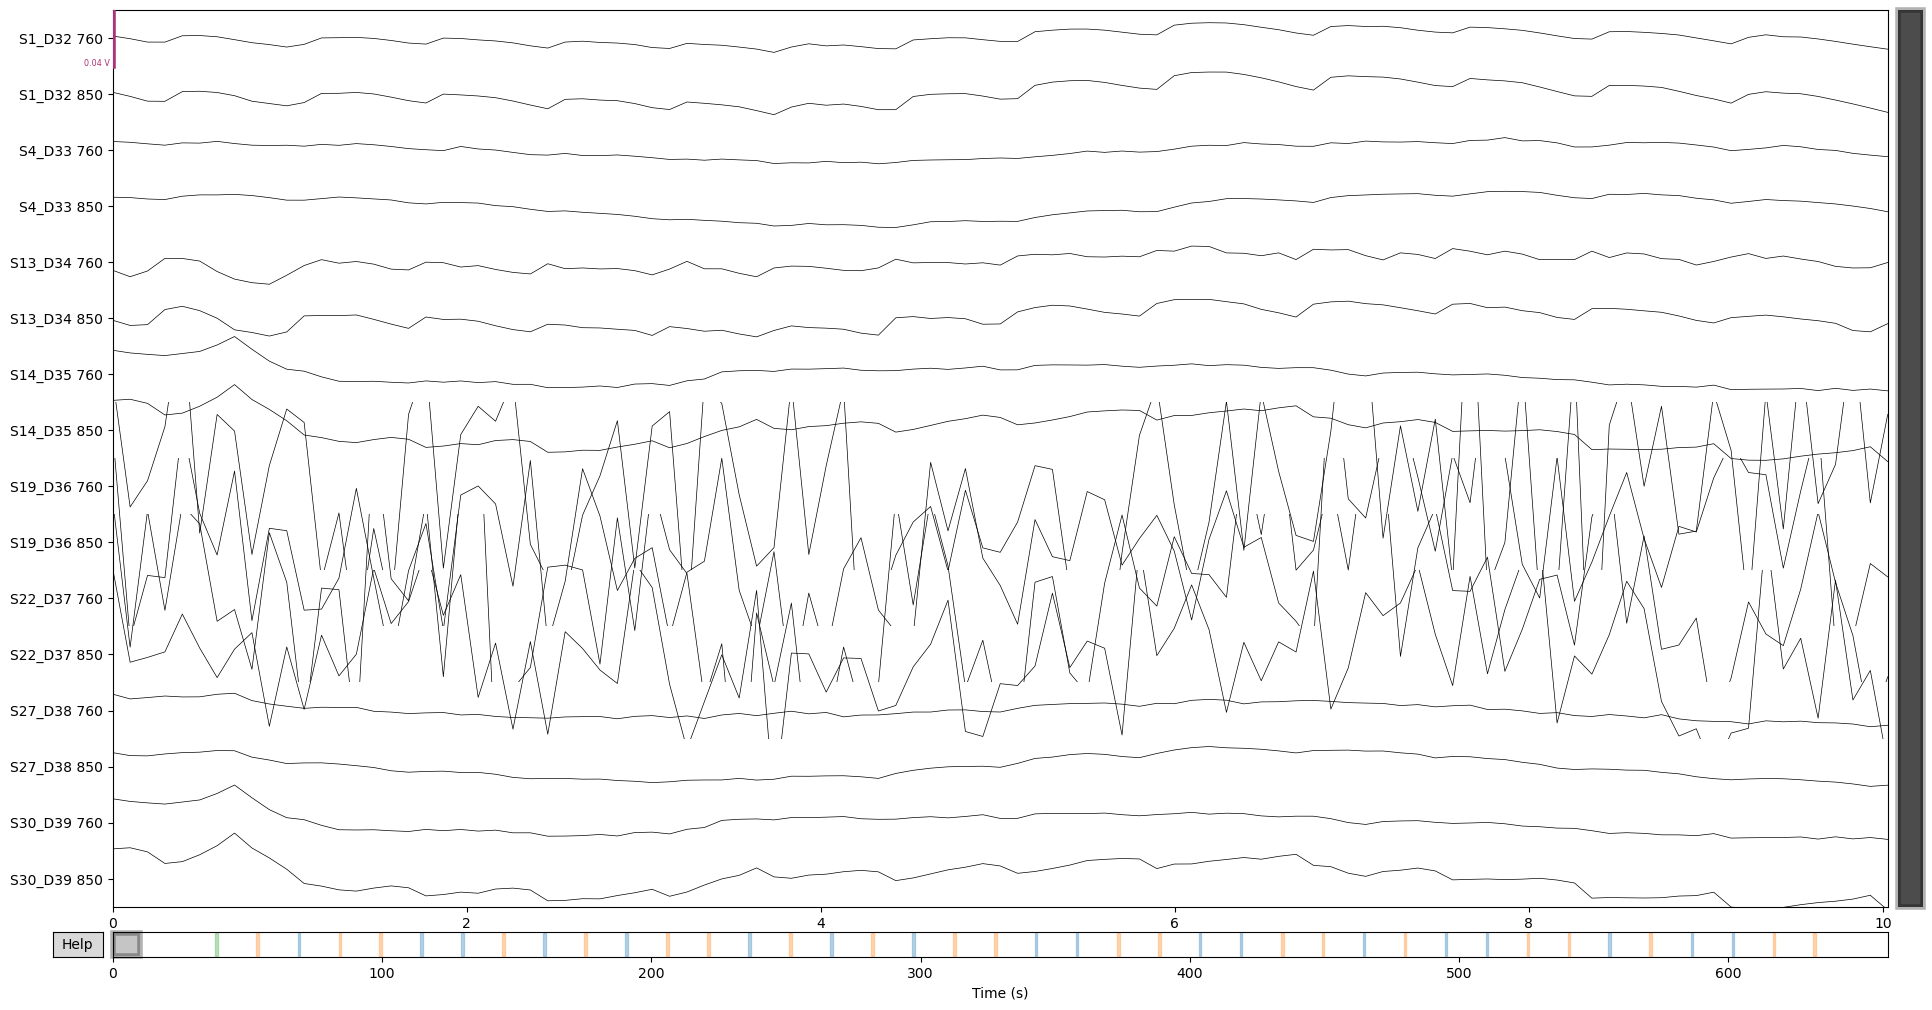

Channels marked as bad:
none


In [504]:
raw_od_shorts.plot()

In [505]:
filename = true_fnirs_files[0]

DROP_CHANS = [
 'S2_D4 760',
 'S2_D4 850',]

raw_intensity = mne.io.read_raw_nirx(filename, verbose=False)

raw_od = optical_density(raw_intensity) #from row wavelength data

raw_od_shorts = mne_nirs.channels.get_short_channels(raw_od)
raw_od.drop_channels(DROP_CHANS) #we had a non-existent channel

raw_od = mne_nirs.signal_enhancement.short_channel_regression(raw_od)

raw_od = mne_nirs.channels.get_long_channels(raw_od)
raw_od = temporal_derivative_distribution_repair(raw_od) #repairs movement artifacts

raw_haemo = beer_lambert_law(raw_od, ppf=0.1) #from wavelength to HbO\HbR
raw_haemo = raw_haemo.filter(**FILTER_DICT)
raw_haemo = enhance_negative_correlation(raw_haemo)

######################################
ids_target= 'SMR'
ids_rest = 'REST'

events, ids = events_from_annotations(raw_haemo)
ids[ids_target] = 1
ids[ids_rest] = 2

IDS_TO_POP = ["2.0", "33.0", "1.0", "2", "1", "33"]
ids_to_pop = IDS_TO_POP
for i in ids_to_pop:
    popper(ids, i)
    
tmin = float(-1.5)
tmax = float(15.0)
baseline = (-1.5, 0)

epochs = mne.Epochs(
                    raw=raw_haemo,
                    events=events,
                    event_id=ids,
                    baseline=baseline,
                    tmin=tmin,
                    tmax=tmax,
                    preload=True,
                    verbose=False,
                    # picks=picks
                )
epochs.resample(2)

rest_epochs_raw = epochs['REST']
smr_epochs_raw = epochs['SMR']

median_smr, smr_reject_bool = epochs_rejector(smr_epochs_raw, sfreq=2,
                                  ch_pick = different_roi['M1'][0],
                                  apply='lower',
                                  time_limits = (5, 12)
                                  )

median_rest, rest_reject_bool = epochs_rejector(rest_epochs_raw, sfreq=2,
                                   ch_pick = different_roi['M1'][0],
                                   apply='upper',
                                   time_limits = (5, 12)
                                   )
smr_epochs_raw = smr_epochs_raw.drop(smr_reject_bool)
rest_epochs_raw = rest_epochs_raw.drop(rest_reject_bool)



Reading 0 ... 6704  =      0.000 ...   659.030 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_11220\3881555941.py:20: RuntimeWarning: filter_length (13429) is longer than the signal (6705), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(**FILTER_DICT)


Used Annotations descriptions: ['1.0', '2.0', '33.0']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dropped 0 epochs: 
Dropped 0 epochs: 


C:\Users\Admin\AppData\Local\Temp\ipykernel_11220\2428755195.py:38: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs.copy().pick_channels(ch_pick)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11220\2428755195.py:38: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs.copy().pick_channels(ch_pick)


In [506]:
import os

def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

def fast_scanfiles(dirname, contains=None):
    subfiles = [f.path for f in os.scandir(dirname) if f.is_file()]
    if contains != None:
        subfiles = [i for i in subfiles if contains in i ]
    return subfiles

def fast_scanfiles_subjfiles(dirname, contains=None):
    subfolders = fast_scandir(dirname)
    subfiles = []
    subfiles.extend(fast_scanfiles(dirname, contains=contains))
    for dirs in subfolders:
        subfiles.extend(fast_scanfiles(dirs, contains=contains))
    return subfiles

In [507]:
def epochs_rejector(epochs, ch_pick, sfreq, criterion='median',
                    time_limits = (4, 12),
                    apply='lower',
                    lower=-5e-6, 
                    upper=5e-6
                   ): 

    time_limits = (time_limits[0]*sfreq, time_limits[1]*sfreq)
    epochs.copy().pick_channels(ch_pick)
    epochs_data = epochs.get_data()[:, :, time_limits[0]:time_limits[1]]

    if apply == 'lower':
        median = np.mean(epochs_data, axis=1)
        median = np.min(median, axis=1)
        reject_bool = median < lower
        
    elif apply == 'upper':
        median = np.mean(epochs_data, axis=1)
        median = np.max(median, axis=1)
        reject_bool = median > upper
        
    return median, reject_bool

def popper(ids, ids_key):
    try:
        ids.pop(ids_key)
    except:
        pass

In [508]:
%matplotlib auto

Using matplotlib backend: QtAgg


In [577]:
#define your filtering parameters

LFREQ = 0.02
HFREQ = 0.1
H_TRANS_BANDWIDTH = 0.1
L_TRANS_BANDWIDTH = 0.01

METHOD = 'fir'
F_TYPE = 'butter'
ORDER = 2
RIPPLE = 1.0
FIR_DESIGN ='firwin2'

IIR_FILTER_PARAMS = dict(
                          order=ORDER, 
                          ftype=F_TYPE,
#                           rp=RIPPLE
                          )


if METHOD == 'iir':
    FILTER_DICT = dict(
                        l_freq=LFREQ, 
                        h_freq=HFREQ,                     
                        method=METHOD, 
                        iir_params=IIR_FILTER_PARAMS, 
                        verbose=False,
                      )

elif METHOD == 'fir':
    FILTER_DICT = dict(
                        l_freq=LFREQ, 
                        h_freq=HFREQ, 
                        method=METHOD,
                        h_trans_bandwidth=H_TRANS_BANDWIDTH,
                        l_trans_bandwidth=L_TRANS_BANDWIDTH,
                        fir_design=FIR_DESIGN,
                        verbose=False,
                      )

In [571]:
filename = true_fnirs_files[0]
filename

'C:\\Users\\Admin\\Desktop\\IMAGERY-FNIRS\\AA\\AA_ME'

In [616]:
filename = true_fnirs_files[0]
filename


DROP_CHANS = [
 'S2_D4 760',
 'S2_D4 850',]

raw_intensity = mne.io.read_raw_nirx(filename, verbose=False)
raw_od = optical_density(raw_intensity) #from row wavelength data

raw_od_shorts = mne_nirs.channels.get_short_channels(raw_od)
raw_od.drop_channels(DROP_CHANS) #we had a non-existent channel

raw_od = mne_nirs.signal_enhancement.short_channel_regression(raw_od)
raw_od = mne_nirs.channels.get_long_channels(raw_od)
raw_od = temporal_derivative_distribution_repair(raw_od) #repairs movement artifacts
raw_od = raw_od.filter(**FILTER_DICT)

raw_haemo = beer_lambert_law(raw_od, ppf=0.1) #from wavelength to HbO\HbR
raw_haemo = enhance_negative_correlation(raw_haemo)

######################################
ids_target= 'SMR'
ids_rest = 'REST'

events, ids = events_from_annotations(raw_haemo)
ids[ids_target] = 1
ids[ids_rest] = 2

IDS_TO_POP = ["2.0", "33.0", "1.0", "2", "1", "33"]
ids_to_pop = IDS_TO_POP
for i in ids_to_pop:
    popper(ids, i)
    
tmin = float(-1.5)
tmax = float(14.0)
baseline = (-1.5, 0)

epochs = mne.Epochs(
                    raw=raw_haemo,
                    events=events,
                    event_id=ids,
                    baseline=baseline,
                    tmin=tmin,
                    tmax=tmax,
                    preload=True,
                    verbose=False,
                    # picks=picks
                )

epochs.resample(2)

rest_epochs_raw = epochs['REST']
smr_epochs_raw = epochs['SMR']

# median_smr, smr_reject_bool = epochs_rejector(smr_epochs_raw, sfreq=2,
#                                   ch_pick = different_roi['M1'][0],
#                                   apply='lower',
#                                   time_limits = (5, 12)
#                                   )

# median_rest, rest_reject_bool = epochs_rejector(rest_epochs_raw, sfreq=2,
#                                    ch_pick = different_roi['M1'][0],
#                                    apply='upper',
#                                    time_limits = (5, 12)
#                                    )
# smr_epochs_raw = smr_epochs_raw.drop(smr_reject_bool)
# rest_epochs_raw = rest_epochs_raw.drop(rest_reject_bool)



Reading 0 ... 6704  =      0.000 ...   659.030 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_11220\2977146403.py:18: RuntimeWarning: filter_length (6715) is longer than the signal (6705), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od = raw_od.filter(**FILTER_DICT)


Used Annotations descriptions: ['1.0', '2.0', '33.0']


In [674]:
hbo_smr = smr_epochs_raw.copy().pick_types(fnirs='hbo')
arr = hbo_smr.get_data()
arr1 = smr_epochs_raw.copy().pick(M1_LEFT_ROI_HBO)
mean_epochs = np.mean(arr, axis=0)
mean_channels = np.mean(arr1, axis=1)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [696]:
arr_mean = np.mean(arr, axis=0)
arr_mean.shape

(102, 31)

In [745]:
colors = [
          (0.176, 0.000, 0.263),
          (0.384, 0.071, 0.482),
          (0.604, 0.141, 0.655),
          (0.788, 0.224, 0.706),
          (0.945, 0.345, 0.643),
          (0.992, 0.518, 0.384),
          (0.902, 0.725, 0.129),
          (0.969, 0.890, 0.216),
          (0.988, 0.984, 0.576),
          (0.988, 0.969, 0.824),
          (0.976, 0.973, 0.992),
          (0.902, 0.902, 0.902),
          (0.776, 0.776, 0.776),
          (0.612, 0.612, 0.612),
          (0.412, 0.412, 0.412)
         ]

cmap_porsche = matplotlib.colors.LinearSegmentedColormap.from_list('custom_porsche_cmap', colors, N=256)

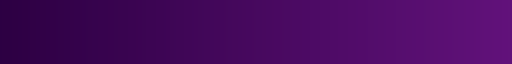

In [746]:
cmap_porsche

In [750]:
n_times = np.arange(2, 16, 2)
vlim = (-7e-6, 7e-6)

fig, axes = plt.subplots(1, len(n_times), figsize=(20, 12))

cmap = 'hot'
for idx, ax in enumerate(axes):
    
    mne.viz.plot_topomap(data=arr_mean[:, n_times[idx]*2],
                        pos=topo_info,
                        axes=ax,
                        vlim=vlim,
                        contours=0,
                        extrapolate='local',
                        image_interp='cubic',
                        cmap=cmap
                         
                        )
    ax.set_title(f'{n_times[idx]} s')

sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=matplotlib.colors.Normalize(vmin=vlim[0], vmax=vlim[1]))

cbaxes = fig.add_axes([0.075, 0.25, 0.02, 0.5]) # setup colorbar axes. 
cbar = plt.colorbar(mappable=sm, cax=cbaxes, pad=0.15, orientation='vertical')

cbar.set_label(' Hb concentration, Δ μM\L', loc='center', size=12)
cbar.ax.yaxis.set_label_coords(-0.5, 0.5)




In [609]:
smr_hbo_left, rest_hbo_left, info_left, smr_hbo_left_total, rest_hbo_left_total = make_evokeds_roi(smr_epochs=smr_epochs_raw, 
                 rest_epochs=rest_epochs_raw, 
                 pick=different_roi['M1'][0])
smr_mean_hbo_left, rest_mean_hbo_left = smr_hbo_left.mean(axis=0), rest_hbo_left.mean(axis=0)

smr_hbr_left, rest_hbr_left, info_hbr, smr_hbr_left_total, rest_hbr_left_total = make_evokeds_roi(smr_epochs=smr_epochs_raw, 
                 rest_epochs=rest_epochs_raw, 
                 pick=different_roi['M1'][1])
smr_mean_hbr_left, rest_mean_hbr_left = smr_hbr_left.mean(axis=0), rest_hbr_left.mean(axis=0)

smr_hbo_right, rest_hbo_right, info_right, smr_hbo_right_total, rest_hbo_right_total = make_evokeds_roi(smr_epochs=smr_epochs_raw, 
                 rest_epochs=rest_epochs_raw, 
                 pick=different_roi['M1'][2])
smr_mean_hbo_right, rest_mean_hbo_right = smr_hbo_right.mean(axis=0), rest_hbo_right.mean(axis=0)

smr_hbr_right, rest_hbr_right, info_hbr, smr_hbr_right_total, rest_hbr_right_total = make_evokeds_roi(smr_epochs=smr_epochs_raw, 
                 rest_epochs=rest_epochs_raw, 
                 pick=different_roi['M1'][3])
smr_mean_hbr_right, rest_mean_hbr_right = smr_hbr_right.mean(axis=0), rest_hbr_right.mean(axis=0)

times = np.arange(tmin, tmax, 1/info_left['sfreq'])
ax = plt.subplot(111)
ax.plot(times, smr_hbo_left_total.T, alpha=0.1, color='red')
ax.plot(times, smr_hbo_left_total.mean(axis=0), color='red', alpha=1, label='SMR')

ax.plot(times, rest_hbo_left_total.T, alpha=0.1, color='green')
ax.plot(times, rest_hbo_left_total.mean(axis=0), color='green', alpha=1, label='REST')
ax.set_xlim(tmin, tmax)
ax.set_ylim(-20e-6, 20e-6)
ax.legend()

In [610]:
std_err = np.std(rest_hbo_left_total, axis=0)

In [611]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# m, lower, upper = mean_confidence_interval(rest_hbo_left_total)

lower, upper = smr_mean_hbo_left - std_err, smr_mean_hbo_left + std_err
# confidence_intervals = np.percentile(smr_hbo_left_total, [2.5, 97.5], axis=0)


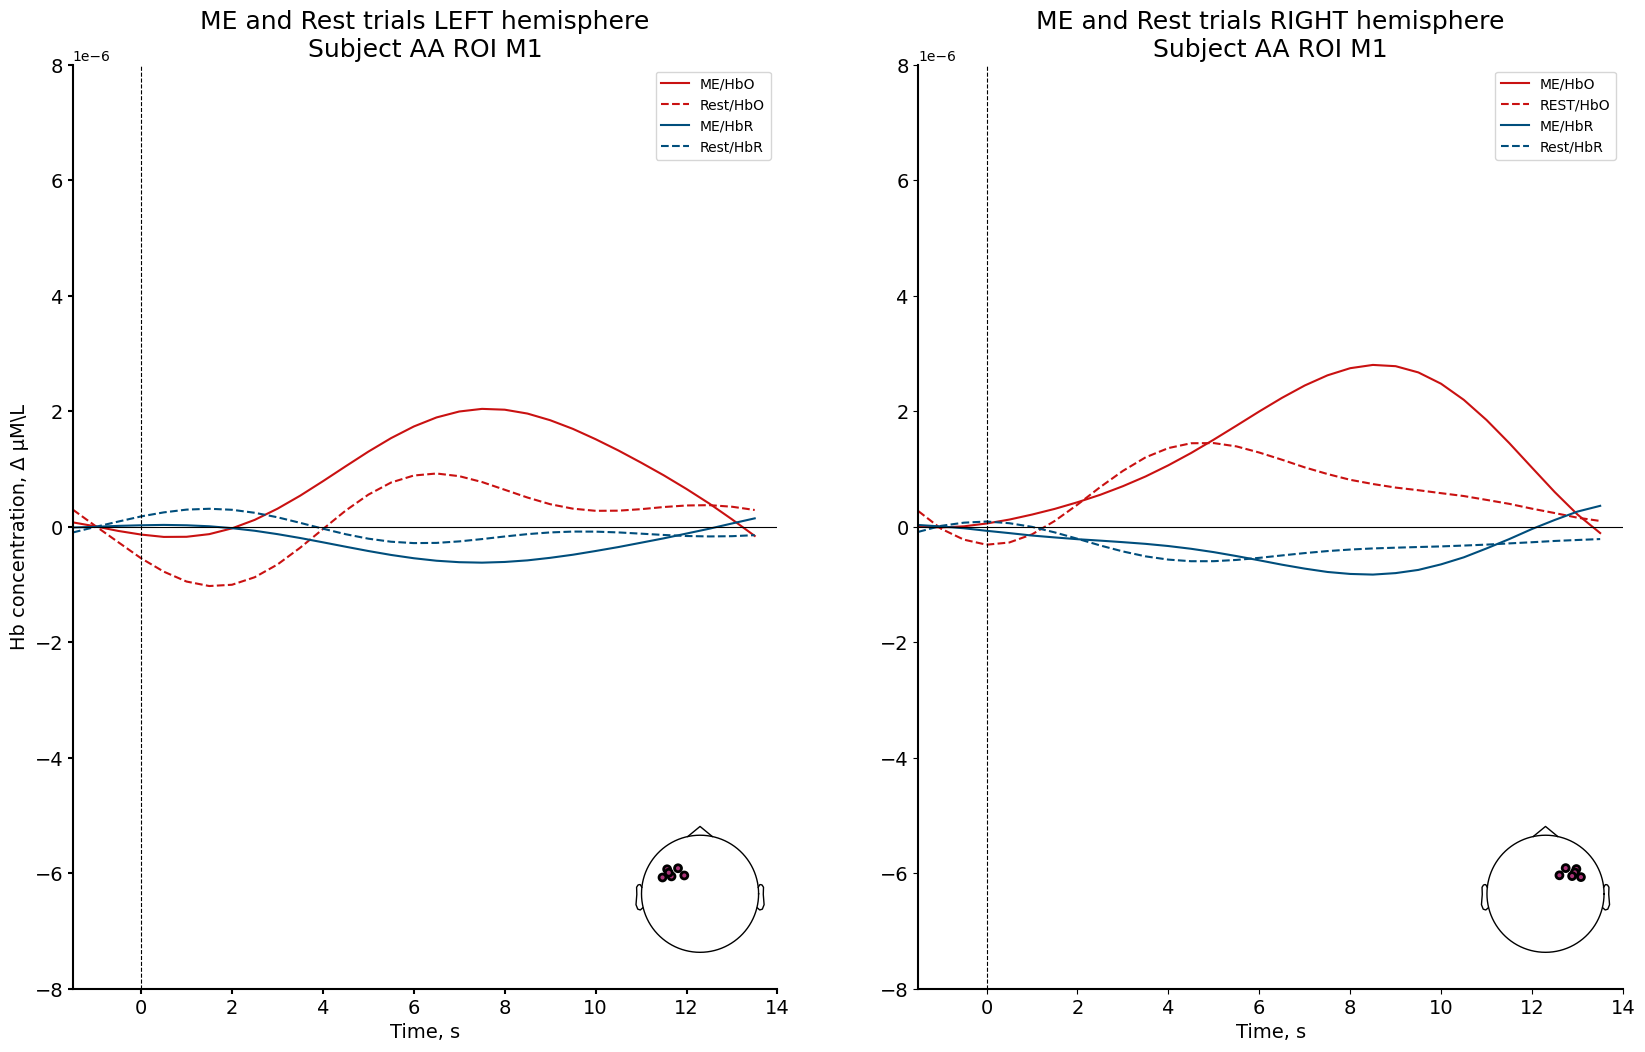

In [612]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

CONDITION = 'ME'
SUBJECT = 'AA'
roi = 'M1'
fig, axes = plt.subplots(1, 2, figsize=(20, 12))
times = np.arange(tmin, tmax, 1/info_left['sfreq'])
linewidth = 1.5

####LEFT PART#############

axes[0].plot(times, smr_mean_hbo_left, label=f'{CONDITION}/HbO', 
             color=porsche_colors['Guards Red'])
axes[0].plot(times, rest_mean_hbo_left, label='Rest/HbO', 
             color=porsche_colors['Guards Red'], 
             linestyle='--')
axes[0].plot(times, smr_mean_hbr_left, label=f'{CONDITION}/HbR', 
             color=porsche_colors['Sapphire Blue'])
axes[0].plot(times, rest_mean_hbr_left, label='Rest/HbR', 
             color=porsche_colors['Sapphire Blue'], 
             linestyle='--')

# axes[0].fill_between(times, lower, upper,
#                      color=porsche_colors['Guards Red'], alpha=0.2)
# axes[0].errorbar(times, smr_mean_hbo_left, 
#                  yerr=[lower, upper], 
#                  fmt='-', 
#                  color=porsche_colors['Guards Red'])

axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].legend()

axes[0].set_xlim(tmin, tmax)
axes[0].set_ylim(-8e-6, 8e-6)
axes[0].set_xlabel('Time, s',
                  fontsize=14)
axes[0].tick_params(axis='x', 
               labelsize=14)
axes[0].tick_params(axis='y', 
               labelsize=14)
axes[0].xaxis.set_tick_params(width=linewidth)
axes[0].yaxis.set_tick_params(width=linewidth)
for i in axes[0].spines.values():
   i.set_linewidth(linewidth)
axes[0].set_ylabel('Hb concentration, Δ μM\L',
                  fontsize=14)
linewidth = ax.spines['bottom'].get_linewidth()
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=linewidth)
axes[0].axhline(y=0, color='black', linewidth=linewidth)
axes[0].set_title(f'{CONDITION} and Rest trials LEFT hemisphere\nSubject {SUBJECT} ROI {roi}',
                 fontsize=18)
inset_ax = inset_axes(axes[0], width="20%", height="20%", loc="lower right")
mne.viz.plot_sensors(info=info_left, axes=inset_ax)


####RIGHT PART#############

axes[1].plot(times, smr_mean_hbo_right, label=f'{CONDITION}/HbO', color=porsche_colors['Guards Red'])
axes[1].plot(times, rest_mean_hbo_right, label='REST/HbO', color=porsche_colors['Guards Red'], 
             linestyle='--')
axes[1].plot(times, smr_mean_hbr_right, label=f'{CONDITION}/HbR', color=porsche_colors['Sapphire Blue'])
axes[1].plot(times, rest_mean_hbr_right, label='Rest/HbR', color=porsche_colors['Sapphire Blue'], 
             linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].legend()
axes[1].set_xlim(tmin, tmax)
axes[1].set_ylim(-8e-6, 8e-6)
axes[1].set_xlabel('Time, s',
                  fontsize=14)
axes[1].tick_params(axis='x', 
               labelsize=14)
axes[1].tick_params(axis='y', 
               labelsize=14)
axes[1].xaxis.set_tick_params(width=linewidth)
axes[1].yaxis.set_tick_params(width=linewidth)
for i in axes[1].spines.values():
   i.set_linewidth(1.5)
linewidth = ax.spines['bottom'].get_linewidth()
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=linewidth)
axes[1].axhline(y=0, color='black', linewidth=linewidth)
axes[1].set_title(f'{CONDITION} and Rest trials RIGHT hemisphere\nSubject {SUBJECT} ROI {roi}',
                 fontsize=18)
inset_ax = inset_axes(axes[1], width="20%", height="20%", loc="lower right")
mne.viz.plot_sensors(info=info_right, axes=inset_ax)



In [124]:
porsche_colors = {
    'Black': '#0D0D0D',
    'White': '#F7F7F7',
    'Guards Red': '#C91111',
    'Carmine Red': '#960018',
    'Papaya': '#FFC173',
    'Racing Yellow': '#FFB400',
    'Speed Yellow': '#FFB400',
    'Signal Yellow': '#F5AB35',
    'Viper Green': '#2A7D4D',
    'Irish Green': '#00574C',
    'Gulf Blue': '#0087B8',
    'Miami Blue': '#22A0D4',
    'Sapphire Blue': '#004E7C',
    'Night Blue': '#0F3B5C',
    'Mexico Blue': '#00A1D6',
    'Riveria Blue': '#005D7E',
    'GT Silver Metallic': '#A0A0A0',
    'Agate Grey Metallic': '#828282',
    'Chalk': '#E8E8E8',
    'Crayon': '#A2A2A2',
    'Dolomite Silver Metallic': '#7A7A7A',
    'Jet Black Metallic': '#1D1D1D',
    'Mahogany Metallic': '#672023',
    'Moonlight Blue Metallic': '#202A44',
    'Night Blue Metallic': '#0F3B5C',
    'Quartzite Grey Metallic': '#717171',
    'Rhodium Silver Metallic': '#A0A0A0',
    'Sapphire Blue Metallic': '#004E7C',
    'Vulcano Grey Metallic': '#7E7E7E',
    'Crayon Metallic': '#A2A2A2',
    'Python Green': '#007C59',
    'Lava Orange': '#FF4E09',
    'Lizard Green': '#5D8B35',
    'Mamba Green': '#0C6E3D',
    'Mint Green': '#78A086',
    'Riviera Blue': '#005D7E'
}